In [123]:
#List of imports

import pandas as pd
import scipy.optimize as sco
import numpy as np
import pandas_datareader as web
import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.api as smf
import urllib.request
import zipfile
import cvxpy as cp
from copy import deepcopy
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import scipy.optimize as sco
import numpy as np
import pandas_datareader as web
import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as smf
import urllib.request
import zipfile

from math import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [124]:
def get_mu_Q_multiperiod(exRets, factor_data, lookahead, lookback, regress_type="Linear"):
    """
    exRets: excess return data for stocks
    factor_data: factor return data
    lookahead: number of periods in the future to estimate
    lookback: number of periods in the past to use for estimations
    regress_type: can be 'Linear', 'Lasso', or 'Ridge'
    """
    
    # For keeping track of mu's and Q's from each period
    mu_arr = []
    Q_arr = []
            
    n_factors = len(factor_data.columns)
    factor_data = factor_data.tail(lookback)
    exRets = exRets.tail(lookback)
    factor_data = deepcopy(factor_data)
    
    for i in range(0, lookahead):

        # Calculate the factor covariance matrix
        F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()
        
        # Calculate the factor expected excess return from historical data using the geometric mean
        factor_data.loc[:, 'Ones'] = 1
        gmean = stats.gmean(factor_data + 1,axis=0) - 1

        # Set up X and Y to determine alpha and beta
        X = factor_data
        Y = exRets
        X = X.to_numpy()
        Y = Y.to_numpy()

       # Determine alpha and beta
        if regress_type=="Linear":
            model = LinearRegression().fit(X,Y)
        elif regress_type=="Lasso":
            model = Lasso().fit(X,Y)
        elif regress_type=="Ridge":
            model = Ridge().fit(X,Y)
        else:
            print("Error: This type of regression has not been implemented.")
        alpha = model.intercept_
        beta = model.coef_[:,0:n_factors]

        # Calculate the residuals 
        alpha = np.reshape(alpha,(alpha.size,1))
        epsilon = exRets.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

        # Calculate the residual variance with "N - p - 1" degrees of freedom
        p = 3
        sigmaEp = np.sum(epsilon**2, axis=0) / (len(exRets) - 1 - p)

        #  Calculate the asset expected excess returns
        mu = model.predict([gmean])[0]

        # Calculate the diagonal matrix of residuals and the asset covariance matrix
        D = np.diag(sigmaEp)

        # Calculate the covariance matrix
        Q = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D
        
        # Add mu and Q to array
        mu_arr.append(mu)
        Q_arr.append(Q)
        
        # Update for next time step
        factor_data = factor_data[1:]
        factor_append = pd.Series(gmean, index = factor_data.columns)
        factor_data=factor_data.append(factor_append, ignore_index=True)
        
        exRets = exRets[1:]
        mu_append = pd.Series(mu, index=exRets.columns)
        exRets = exRets.append(mu_append, ignore_index=True)   
        
    return mu_arr, Q_arr

In [116]:

class data:
    #Anything Data Related
    def __init__(self, stock_prices, universe):
        self.factor_returns=None
        self.stock_returns=None
        
        if type(universe[0])== int:
            self.stock_prices=stock_prices.iloc[:,universe]

        else:
            self.stock_prices=stock_prices[universe]
        
        self.stock_prices.index= pd.to_datetime(self.stock_prices.index)

        return
    
    def get_stock_returns(self, period="M"):
        price = self.stock_prices.resample(period).last()

        # Calculate the percent change
        ret_data = price.pct_change()[1:]

        # Convert from series to dataframe
        ret_data = pd.DataFrame(ret_data)

            
        self.stock_returns=ret_data
        return 
    
    def get_factor_returns(self, period="M"):
        ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"    
        # Download the file and save it  
        urllib.request.urlretrieve(ff_url,'fama_french.zip')
        zip_file = zipfile.ZipFile('fama_french.zip', 'r')    
        # Extact the file data
        zip_file.extractall()
        zip_file.close()    
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)   
        # Skip null rows
        ff_row = ff_factors.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = ff_row, index_col = 0)

        # Format the date index
        ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')

        # Format dates to end of month
        ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()

        # Resample the data to correct frequency
        ff_factors = ff_factors.resample(period).last()

        # Convert from percent to decimal
        ff_factors = ff_factors.apply(lambda x: x/ 100)
        self.factor_returns=ff_factors
        
        return
    
    def get_index_from_date(self, date_index_df, date):

        return date_index_df.index.get_loc(date)
    
    def get_lookback_data(self, date_index_df, date, lookback):
        end_idx= self.get_index_from_date(date_index_df, date)
        return date_index_df.iloc[end_idx-lookback:end_idx]      
     



class portfolio:
    #Anything Portfolio related: weights, returns, date-stamped
    def __init__(self, initial_weights):       
        num_assets=len(initial_weights)
        self.weights= np.array([initial_weights])
        self.returns= np.array([])
        self.dates= []
        
    def update_weights(self, new_weights):
        
        new_weights=np.array([new_weights])        
        self.weights=np.append(self.weights,new_weights,axis=0)
     
    
    def update_returns(self, new_returns):
        self.returns=np.append(self.returns, new_returns)
        
    def update_dates(self, new_dates):
       
        self.dates.append(new_dates)
        
    def plot(self):
        port_cumu_returns = np.array([x+1 for x in self.returns]).cumprod()
        plt.figure(figsize=(12,6))
        plt.plot(self.dates, port_cumu_returns)
        plt.xticks(rotation=45)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
    



class constraints:
        #List of all constraints
        def __init__(self, upper_limit, lower_limit, stock_limit):
            self.upper_limit= upper_limit
            self.lower_limit= lower_limit
            self.stock_limit= stock_limit
            self.value=[]

        
        def weight_unity(self, weights):
            self.value+= [cp.sum(weights,axis=0)==1]
       
        def cardinality(self, y):
            self.value+= [cp.sum(y,axis=0)== self.stock_limit]        
        
        def asset_limit_cardinality(self, y, weights):
            cardinality_upper_limit= cp.multiply(self.upper_limit, y)
            cardinality_lower_limit = cp.multiply(self.lower_limit,y)
            self.value+=  [weights>=cardinality_lower_limit, weights<=cardinality_upper_limit]

        
        def no_short(self, weights):
            self.value+=  [weights>=0]
        
        def asset_limit(self, weights):
            self.value+=  [weights>=self.lower_asset_limit, weights<=self.upper_asset_limit]
        

        

class returns:
    def __init__(self):
        self.value=0
    
    def get_returns(self,mu,weights):          
        portfolio_return_per_period= mu@weights
        portfolio_return= cp.trace(portfolio_return_per_period)
        self.value=portfolio_return
    

class risks:
    def __init__(self):
        self.value=0
    
    def get_var(self, weights, Q, look_ahead):
        portfolio_risk=0
        for i in range(look_ahead):
            portfolio_risk+=cp.quad_form(weights[:,i],Q[i])        
        self.value=portfolio_risk
        
    def get_robust_addon(self, weights, Q, look_ahead, num_stocks):
        robustness_cost=0
        for i in range(look_ahead):
            delta= 1.96*np.sqrt(np.diag(Q[i]/num_stocks))
            robustness_cost+= delta@cp.abs(weights[:,i])
        self.value+= robustness_cost

    

class costs:
    def __init__(self, trans_coeff, holding_coeff):
        self.holding_cost= 0
        self.trans_cost= 0
        self.trans_coeff= trans_coeff
        self.holding_coeff= holding_coeff
        
    def replicate_cost_coeff(self, num_stocks, lookahead):
        trans_cost_repl= np.ones((num_stocks,look_ahead))/100
        holding_cost_repl= np.ones((num_stocks, look_ahead))/100
        self.trans_coeff= trans_cost_repl*self.trans_coeff
        self.holding_coeff= holding_cost_repl*self.holding_coeff
    
    def get_holding_cost(self, weights_new):

        return cp.sum(cp.multiply(self.holding_coeff, cp.neg(weights_new)))
        
    def calc_trans_cost(self, weights_new, weights_old, trans_coeff):
        abs_trade= cp.abs(weights_new-weights_old)
        return cp.sum(cp.multiply(trans_coeff, abs_trade))       
    
    
    def get_trans_cost (self, weights_new,weights_old):
        
        weights_curr= weights_new[:,0]
        if weights_new.shape[1]>1:         
            weights_future= weights_new[:,1:]
            weights_future_shift= weights_new[:,:-1]
            self.trans_cost=self.calc_trans_cost(weights_future, weights_future_shift,self.trans_coeff[:,1:])        
        self.trans_cost+=self.calc_trans_cost( weights_curr, weights_old,self.trans_coeff[:,0])        



class model:
    def __init__(self, look_ahead, lam):
        self.look_ahead= look_ahead
        self.lam=lam
        
    def MVO(self,port, mu ,Q, constraint_model, cost_model):
        
        mu_np =np.array(mu)
        Q_np =np.array(Q)
        num_stocks=port.weights.shape[1]

        #Construct optimization problem
        weights=cp.Variable((num_stocks,look_ahead))
        y= cp.Variable((num_stocks,look_ahead), integer=True)
        
        weights_prev= port.weights[-1,:]      

        cost_model.get_trans_cost(weights, weights_prev)
        cost_model.get_holding_cost(weights)        

        constraint_model.weight_unity(weights)
        constraint_model.no_short(weights)
        constraint_model.cardinality(y)
        constraint_model.asset_limit_cardinality(y, weights)    
        
        return_model=returns()
        return_model.get_returns(mu_np, weights)
        
        risk_model= risks()
        risk_model.get_var(weights, Q, self.look_ahead)
        risk_model.get_robust_addon(weights, Q, self.look_ahead, num_stocks)

        #objective= cp.Maximize(return_model.value - self.lam*risk_model.value - cost_model.trans_cost - cost_model.holding_cost)
        objective= cp.Maximize(return_model.value - self.lam*risk_model.value- cost_model.holding_cost-cost_model.trans_cost)
        #Construct Problem and Solve
        prob= cp.Problem(objective, constraint_model.value)
        result=prob.solve(solver="GUROBI")

       

        return np.array(weights.value)[:,1]
    
    
class backtest:
    def __init__(self,rebal_freq, start_date, end_date, lookback, lookahead):
        self.rebal_freq= rebal_freq
        self.start_date= start_date
        self.end_date= end_date
        self.lookback= lookback
        self.lookahead= lookahead
        self.reb_dates=None
        

    
    def run(self, data, portfolio, optimizer, constr, cost):      
        stock_return= data.stock_returns
        factor_return= data.factor_returns        
        self.reb_dates= np.array(data.stock_returns.loc[self.start_date:self.end_date].index)       
 
        for t in self.reb_dates:

            returns_lookback= data.get_lookback_data(stock_return,t,self.lookback)
            factors_lookback= data.get_lookback_data(factor_return,t,self.lookback)

            mu, Q = get_mu_Q_multiperiod(returns_lookback, factors_lookback, self.lookahead, self.lookback, "Lasso")
#             weights = MVO_Cardinality(mu,Q,self.lookahead,portfolio.weights[-1]) 
            
            
            weights=optimizer.MVO(port, mu ,Q, constr, cost)     
            
            portfolio.update_dates(t)
            portfolio.update_weights(weights)
            portfolio.update_returns(np.dot(weights,stock_return.loc[t]))
            

            ##How the lambdas influence
            
            
            
            
            ## Grid Search Regime Switch.. levels of robustness
            
            
            ##When to use MVO.. when to use CVaR... implement a CVaR







In [ ]:
class factor_model:
    def __init__(self, data, lookahead, lookback, model_type="Linear"):
        self.returns_data = data.returns_data
        self.factor_data = data.factor_data
        self.lookahead = lookahead
        self.lookback = lookback
        self.model_type = model_type
               
    def get_param_estimate(self):
               
        if model_type == "LSTM":
            return self.get_mu_LSTM()

        elif model_type == "Linear" or model_type == "Lasso" or model_type == "Ridge" or model_type == "SVR":
            return self.get_mu_Q_regression()
        
        else:
            return "ERROR: This factor model type has not been implemented. Please input one of the following: LSTM, Linear, Lasso, Ridge, SVR."
        
    def get_mu_Q_regression(self): 
        returns_data = self.returns_data
        factor_data = self.factor_data
        lookahead = self.lookahead
        lookback = self.lookback
        regress_type = self.model_type
        
        # For keeping track of mu's and Q's from each period
        mu_arr = []
        Q_arr = []

        n_factors = len(factor_data.columns)
        factor_data = factor_data.tail(lookback)
        returns_data = returns_data.tail(lookback)

        for i in range(0, lookahead):

            # Calculate the factor covariance matrix
            F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()

            # Calculate the factor expected excess return from historical data using the geometric mean
            factor_data['Ones'] = [1 for i in range(len(factor_data))]
            gmean = stats.gmean(factor_data + 1,axis=0) - 1

            # Set up X and Y to determine alpha and beta
            X = factor_data
            Y = returns_data
            X = X.to_numpy()
            Y = Y.to_numpy()

           # Determine alpha and beta
            if regress_type=="Linear":
                model = LinearRegression().fit(X,Y)
                alpha = model.intercept_
                beta = model.coef_[:,0:n_factors]
            elif regress_type=="Lasso":
                model = Lasso().fit(X,Y)
                alpha = model.intercept_
                beta = model.coef_[:,0:n_factors]
            elif regress_type=="Ridge":
                model = Ridge().fit(X,Y)
                alpha = model.intercept_
                beta = model.coef_[:,0:n_factors]
            elif regress_type=="SVR":           
                model = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(C=1, dual=False, loss="squared_epsilon_insensitive"))).fit(X, Y)
                beta = np.array([[model.named_steps['multioutputregressor'].estimators_[i].coef_[0:n_factors] for i in range(len(model.named_steps['multioutputregressor'].estimators_))]])[0]
                alpha = np.array([model.named_steps['multioutputregressor'].estimators_[i].intercept_[0] for i in range(len(model.named_steps['multioutputregressor'].estimators_))])
      

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            p = 3
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - 1 - p)

            #  Calculate the asset expected excess returns
            mu = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D

            # Add mu and Q to array
            mu_arr.append(mu)
            Q_arr.append(Q)

            # Update for next time step
            factor_data = factor_data[1:]
            factor_append = pd.Series(gmean, index = factor_data.columns)
            factor_data = factor_data.append(factor_append, ignore_index=True)

            returns_data = returns_data[1:]
            mu_append = pd.Series(mu, index=returns_data.columns)
            returns_data = returns_data.append(mu_append, ignore_index=True)   

        return mu_arr, Q_arr
        
        
    def get_mu_LSTM(self): 
        returns_data = self.returns_data
        factor_data = self.factor_data
        lookahead = self.lookahead
        lookback = self.lookback
        regress_type = self.model_type
        
        tempx, tempy = self.generate_X_y(factor_data.values, returns_data.values, lookback, lookahead)
        train_x, test_x, train_y, test_y = self.traintest_split(tempx, tempy)

        # scale inputs
        scaled_train_x = (train_x - train_x.min())/(train_x.max() - train_x.min())
        scaled_test_x = (test_x - test_x.min())/(test_x.max() - test_x.min())
        scaled_train_y = (train_y - train_y.min())/(train_y.max() - train_y.min())
        scaled_test_y = (test_y - test_y.min())/(test_y.max() - test_y.min())

        mu = self.get_prediction(train_x, train_y, factor_data, lookback)
        return mu
    
    def generate_X_y(self, factor_data, returns_data, n_lookback, n_lookforward):
        X, y = list(), list()
        in_start = 0
        for i in range(len(factor_data)):
            in_end = in_start + n_lookback
            out_end = in_end + n_lookforward
            # ensure we have enough data for this instance
            if out_end <= len(factor_data):
                X.append(factor_data[in_start:in_end,:])
                y.append(returns_data[in_end:out_end,:])
            in_start += 1
        return np.array(X), np.array(y)
    
    def traintest_split(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test   
    
    def build_model(self, train_x, train_y):
        # define parameters
        verbose, epochs, batch_size = 0, 50, 16
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

        # define model
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(RepeatVector(n_outputs))
        model.add(LSTM(200, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(train_y.shape[2])))
        model.compile(loss='mse', optimizer='adam')
        # fit network
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
        return model
    
    def forecast(self, model, history, n_lookback):
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for lookback data
        input_x = data[-n_lookback:, :]
        # reshape into [1, n_lookback, n]
        input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
        # forecast the next set
        yhat = model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def evaluate_forecasts(self, actual, predicted):
        # calculate overall RMSE
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                for k in range(actual.shape[2]):
                    s += (actual[row, col, k] - predicted[row, col, k])**2
        score = sqrt(s / (actual.shape[0] * actual.shape[1] * actual.shape[2]))
        return score

    def evaluate_model(self, train_x, train_y, test_x, test_y, n_lookback):
        # fit model
        model = self.build_model(train_x, train_y)
        history = [x for x in train_x]
        # walk-forward validation 
        predictions = list()
        for i in range(len(test_x)):
            yhat_sequence = self.forecast(model, history, n_lookback)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next set
            history.append(test_x[i, :])
        # evaluate predictions 
        predictions = np.array(predictions)
        score = self.evaluate_forecasts(test_y, predictions)
        plt.plot(model.history.history['loss'])
        #plt.plot(model.history.history['val_loss'])
        return score
    
    def get_prediction(self, train_x, train_y, factor_data, lookback):
        model = self.build_model(train_x, train_y)
        return self.forecast(model, factor_data.tail(lookback), lookback)
        

In [125]:
##Main


#Set up Data
price_data = pd.read_csv("../Data/sp500df.csv", index_col='Date')
data_set= data(price_data,[i for i in range(20)])
data_set.get_stock_returns()
data_set.get_factor_returns()

#Set Up Portfolio
num_stocks=len(data_set.stock_returns.columns)
initial_weights= [1/num_stocks for i in range (num_stocks)]
port= portfolio(initial_weights)



#Set Up model
rebal_freq="M"
start_date= "2014-10-31"
end_date= "2017-11-01"
lookback=20
look_ahead=5
lam=0.9
trans_coeff=0.2
holding_coeff=0.2


# upper_asset_limit=np.array([1/num_stocks for i in range(num_stocks)])
# upper_asset_limit=np.tile(upper_asset_limit, (look_ahead,1)).transpose()
# lower_asset_limit=np.array([-1/num_stocks for i in range(num_stocks)])
# lower_asset_limit=np.tile(lower_asset_limit, (look_ahead,1)).transpose()
upper_asset_limit=1
lower_asset_limit=-1
stock_limit=5

constr_model=constraints(upper_asset_limit, lower_asset_limit, stock_limit)
cost_model= costs(trans_coeff, holding_coeff)
cost_model.replicate_cost_coeff(num_stocks, look_ahead)
opt_model=model(look_ahead, lam)



back_test_ex= backtest(rebal_freq, start_date, end_date, lookback, lookahead)
back_test_ex.run(data_set, port, opt_model, constr_model, cost_model)

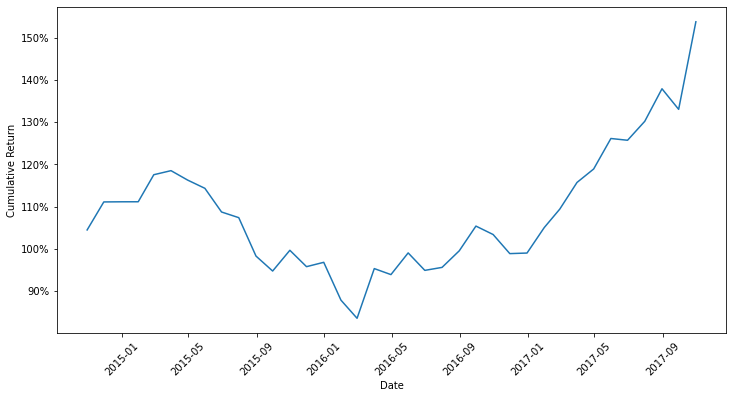

In [126]:
port.plot()

In [127]:
port.weights[2,:]

array([0.0854934 , 0.        , 0.        , 0.72090568, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05      ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.14360092, 0.        ])